# Bibliotecas

In [110]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Funções Auxiliares

In [103]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

def plot_history(history):
    mse = history.history['loss']
    val_mse = history.history['val_loss']
    x = range(1, len(mse) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, mse, 'b', label='Training MSE')
    plt.plot(x, val_mse, 'r', label='Validation MSE')
    plt.title('Training and validation LOSS - MSE')
    plt.xlabel('epoca')
    plt.ylabel('mse')
    plt.legend()

# Carregando os dados iniciais

In [74]:
df = pd.read_csv("solicitacoescredito.csv");
df.head()

,numero_solicitacao,razaoSocial,nomeFantasia,cnpjSemTraco,maiorAtraso,margemBrutaAcumulada,percentualProtestos,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,...,periodoDemonstrativoEmMeses,custos,anoFundacao,intervaloFundacao,capitalSocial,restricoes,empresa_MeEppMei,scorePontualidade,limiteEmpresaAnaliseCredito,dataAprovadoNivelAnalista
0,1,James Richardson-Patel,Alexandra Williams,KEBE17609492220843,0,0.252448,0.0,2015-12-10T00:00:00,0,0.00,...,12.0,0.0,2003.0,Acima de 17 anos,90000.0,False,True,1.0,43200.0,2020-02-03T20:57:33
1,2,Dr. Geoffrey Walsh,Mr. Darren Arnold,JRBK88908250677300,0,0.000000,NaN,2019-06-12T17:28:31,0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,3,Joanna Hudson,Dr. David Rees,GCVQ28531614261293,4,0.624777,0.0,2019-11-27T00:00:00,0,0.00,...,7.0,0.0,2014.0,De 6 a 10 anos,20000.0,False,True,1.0,4320.0,2020-02-04T16:40:49
3,4,Gordon Jones-Hopkins,Sara Reid-Robson,KJND32266018316396,20,0.000000,NaN,2017-02-13T17:20:27,0,0.00,...,12.0,0.0,2013.0,De 6 a 10 anos,30000.0,False,True,0.0,5920.0,2020-02-04T16:37:52
4,5,Nigel Lee,Dr. Stanley Duncan,CGQN15826802440348,20,0.454088,0.0,2010-07-13T00:00:00,20,1486.95,...,9.0,40680051.0,2002.0,Acima de 17 anos,75000.0,False,False,1.0,89000.0,2020-02-04T15:06:28


In [75]:
df_temporal = df[['dataAprovadoNivelAnalista', 'dataAprovadoEmComite', 'valorAprovado']]
df_temporal['dataAprovadoEmComite'].fillna(df_temporal['dataAprovadoNivelAnalista'], inplace=True)
df_temporal.drop('dataAprovadoNivelAnalista', axis=1, inplace=True)
df_temporal.rename({'dataAprovadoEmComite': 'data'}, axis=1, inplace=True)
df_temporal.dropna(inplace=True)
df_temporal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7569 entries, 0 to 8961
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   data           7569 non-null   object 
 1   valorAprovado  7569 non-null   float64
dtypes: float64(1), object(1)
memory usage: 177.4+ KB


In [76]:
df_temporal.data[0][:-9]
df_temporal.data = [x[:-9] for x in df_temporal.data]
df_temporal.valorAprovado = df_temporal.valorAprovado.astype('int64')
df_temporal

,data,valorAprovado
0,2020-02-03,50000
2,2020-02-04,20000
3,2020-02-04,15000
4,2020-02-04,50000
5,2020-02-04,20000
...,...,...
8956,2021-02-25,45000
8957,2021-02-25,15000
8958,2021-02-25,1500000
8960,2021-02-25,20000


In [77]:
df_temporal_agrupado = df_temporal.groupby('data', as_index=False).sum()
df_temporal_agrupado.sort_values('data', inplace=True)
df_temporal_agrupado

,data,valorAprovado
0,2020-02-03,50000
1,2020-02-04,1243000
2,2020-02-05,2952000
3,2020-02-06,5545000
4,2020-02-07,4685000
...,...,...
259,2021-02-19,7911900
260,2021-02-22,4272000
261,2021-02-23,13826500
262,2021-02-24,7255000


In [78]:
df_base_dias = pd.date_range(start='2020-02-03', end='2021-02-25')
df_base_dias = df_base_dias.format(formatter=lambda x: x.strftime('%Y-%m-%d'))
df_base_dias = pd.DataFrame(df_base_dias, columns=['data'])
df_base_dias

,data
0,2020-02-03
1,2020-02-04
2,2020-02-05
3,2020-02-06
4,2020-02-07
...,...
384,2021-02-21
385,2021-02-22
386,2021-02-23
387,2021-02-24


In [121]:
df_temporal = pd.merge(df_base_dias, df_temporal_agrupado, how='left')
df_temporal.data = df_temporal.index + 1
df_temporal.rename({'data': 'dia', 'valorAprovado': 'valor'}, axis=1, inplace=True)
df_temporal.head(20)

,dia,valor
0,1,50000.0
1,2,1243000.0
2,3,2952000.0
3,4,5545000.0
4,5,4685000.0
5,6,NaN
6,7,NaN
7,8,NaN
8,9,746500.0
9,10,3918000.0


In [80]:
df_temporal.isnull().sum()

dia        0
valor    125
dtype: int64

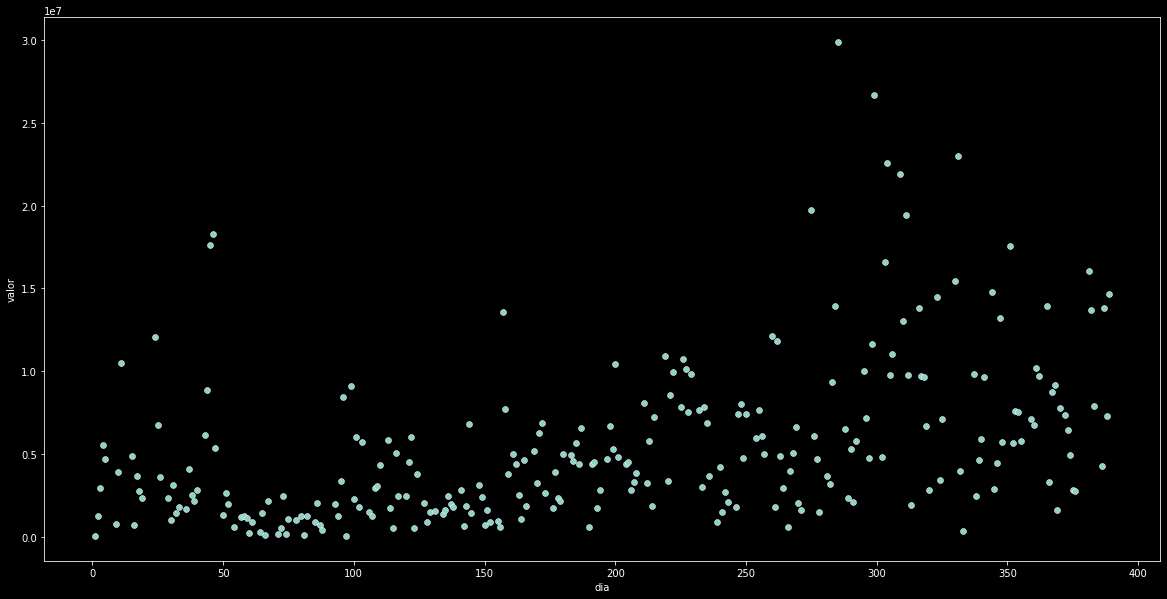

In [118]:
fig = plt.figure(figsize=(20,10))
sns.scatterplot(x=df_temporal.dia, y=df_temporal.valor)
plt.show()

In [122]:
imputer = KNNImputer(n_neighbors=10)
#df_knn = imputer.fit_transform(df_teste['valorAprovado'].reset_index())
knn = imputer.fit_transform(df_temporal)
knn = knn.astype('int64')
knn

array([[       1,    50000],
       [       2,  1243000],
       [       3,  2952000],
       [       4,  5545000],
       [       5,  4685000],
       [       6,  3524250],
       [       7,  3524250],
       [       8,  3524250],
       [       9,   746500],
       [      10,  3918000],
       [      11, 10493000],
       [      12,  3970670],
       [      13,  3970670],
       [      14,  4621920],
       [      15,  4888000],
       [      16,   722000],
       [      17,  3641400],
       [      18,  2737800],
       [      19,  2330000],
       [      20,  4956330],
       [      21,  4007430],
       [      22,  4007430],
       [      23,  4007430],
       [      24, 12057500],
       [      25,  6766400],
       [      26,  3601200],
       [      27,  3712785],
       [      28,  3603505],
       [      29,  2326000],
       [      30,  1004000],
       [      31,  3133000],
       [      32,  1415000],
       [      33,  1756950],
       [      34,  2287134],
       [      

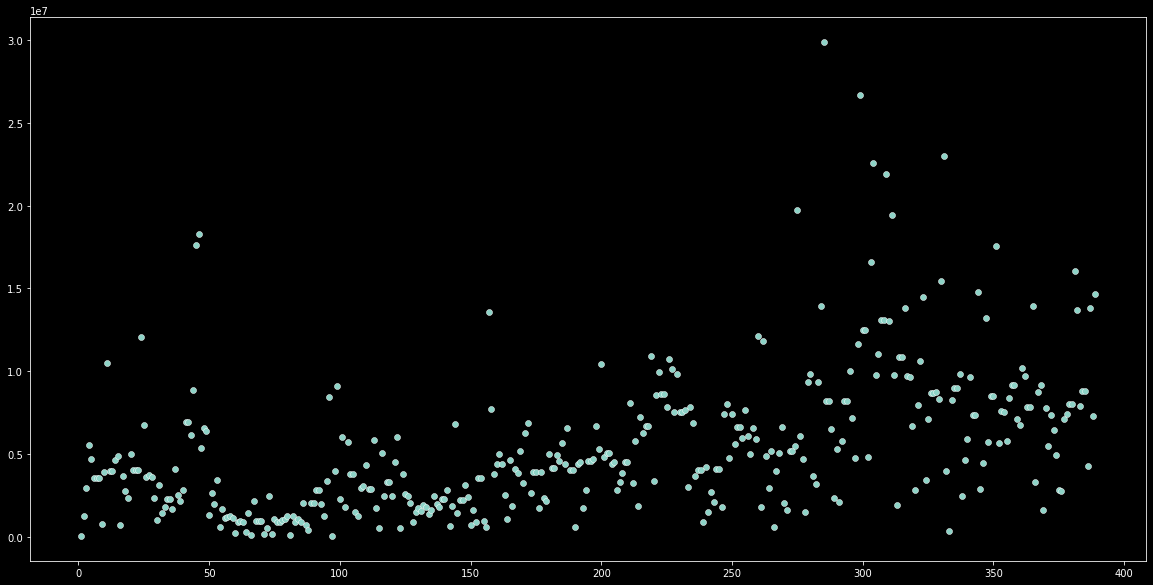

In [123]:
fig = plt.figure(figsize=(20,10))
sns.scatterplot(x=knn[:,0], y=knn[:,1])
plt.show()

In [124]:
X = knn[:,1]
X = X.astype('float32').reshape(-1,1)

In [125]:
X.shape

(389, 1)

In [126]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
X = scaler.fit_transform(X)

In [127]:
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size

train = X[0:train_size,:]
test =  X[train_size:len(X),:]

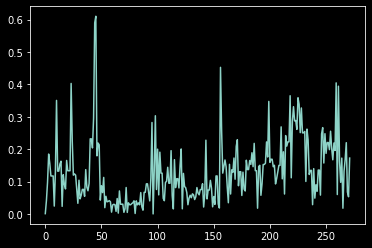

In [128]:
plt.plot(train)

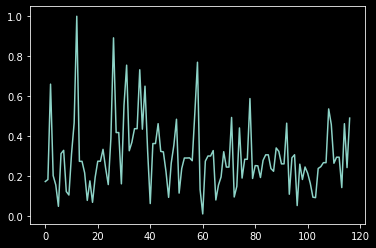

In [129]:
plt.plot(test)

In [148]:
# quantidade de atrasos
look_back = 1

X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)


In [149]:
# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [150]:
X_train.shape

(270, 1, 1)

In [151]:
# Cria e treina a rede LSTM
model = Sequential()
model.add(LSTM(8, input_shape=(look_back, 1)))
#model.add(Dropout(0.5))
#model.add(Dense(32))
#model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [152]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 8)                 320       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [153]:
checkpointer = ModelCheckpoint(filepath='./modelo_lstm_ex4.hdf5', verbose=1, save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1, callbacks=[checkpointer])

Epoch 1/100
261/270 [============================>.] - ETA: 0s - loss: 0.0121
Epoch 00001: val_loss improved from inf to 0.05461, saving model to .\modelo_lstm_ex4.hdf5
270/270 [==============================] - 1s 5ms/step - loss: 0.0118 - val_loss: 0.0546
Epoch 2/100
260/270 [===========================>..] - ETA: 0s - loss: 0.0086
Epoch 00002: val_loss improved from 0.05461 to 0.05233, saving model to .\modelo_lstm_ex4.hdf5
270/270 [==============================] - 1s 4ms/step - loss: 0.0087 - val_loss: 0.0523
Epoch 3/100
261/270 [============================>.] - ETA: 0s - loss: 0.0077
Epoch 00003: val_loss improved from 0.05233 to 0.05087, saving model to .\modelo_lstm_ex4.hdf5
270/270 [==============================] - 1s 4ms/step - loss: 0.0083 - val_loss: 0.0509
Epoch 4/100
263/270 [============================>.] - ETA: 0s - loss: 0.0080
Epoch 00004: val_loss improved from 0.05087 to 0.04529, saving model to .\modelo_lstm_ex4.hdf5
270/270 [==============================] - 1s

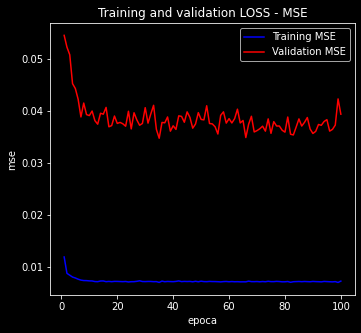

In [154]:
plot_history(history)

In [155]:
model = load_model("./modelo_lstm_ex4.hdf5")

In [156]:
# Predições
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [157]:
# Faz a transformação inversa das predições
trainPredict = scaler.inverse_transform(trainPredict)
y_tr = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_te = scaler.inverse_transform([y_test])

In [158]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(y_tr[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_te[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2564575.67 RMSE
Test Score: 5568130.99 RMSE


In [159]:
# Prepara o vetor para plotagem do conjunto de treinamento
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

In [160]:
# Prepara o vetor para plotagem do conjunto das predições
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(X)-2, :] = testPredict

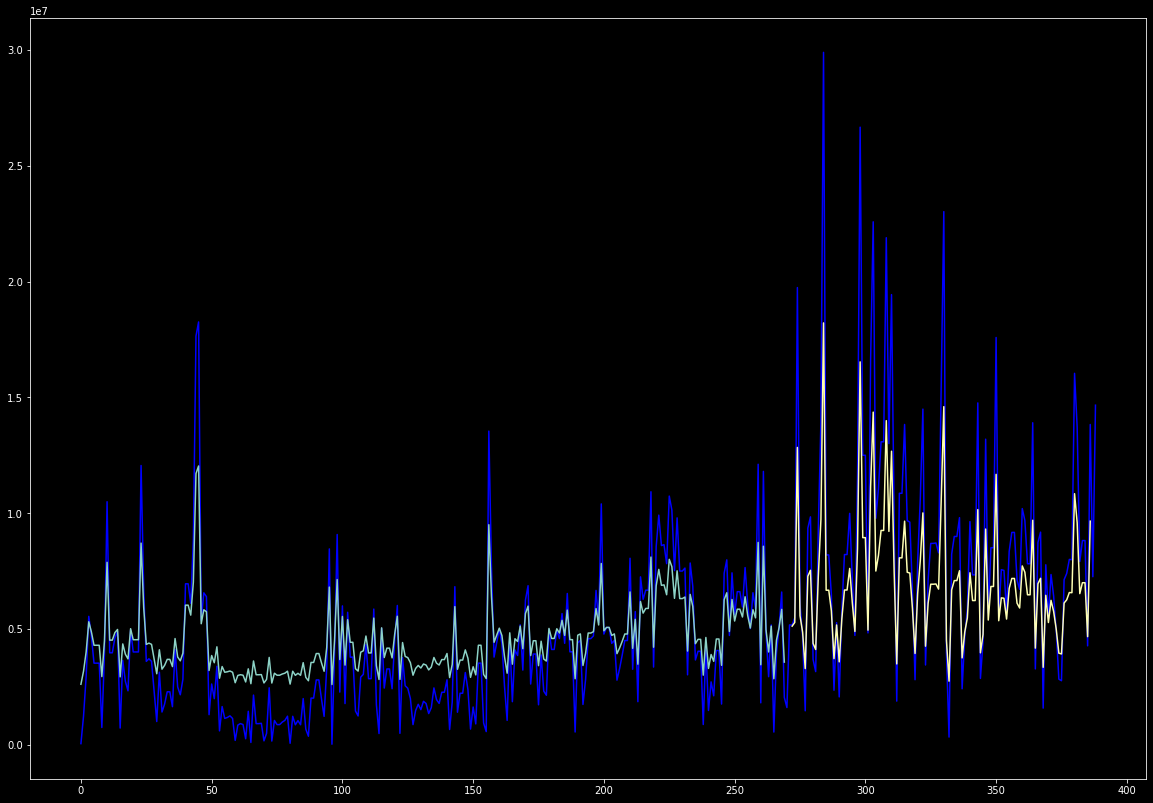

In [161]:
# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(20,14))
plt.plot(scaler.inverse_transform(X), color='b')
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()